In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import numpy as np
import os
import random
import matplotlib.pyplot as plt

from model import CNNModel


def generate():
    # ====================================================
    # 0. Load Model and Extract Weights
    # ====================================================
    model = CNNModel()
    model.eval()
    params = list(model.parameters())
    weight_ori = [p.detach().cpu().numpy() for p in params]

    # ====================================================
    # 1. Load random MNIST image and preprocess
    # ====================================================
    mnist = datasets.MNIST(
        root='C:/Users/isang/OneDrive/Desktop/Python/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
    )
    idx = random.randint(0, len(mnist) - 1)
    mnist_img, mnist_label = mnist[idx]

    # --- Visualize selected sample ---
    plt.imshow(mnist_img.squeeze(0).numpy(), cmap='gray')
    plt.title(f'Selected MNIST index: {idx}, Label: {mnist_label}')
    plt.axis('off')
    plt.show()

    # Convert MNIST tensor to numpy image [28,28]
    img_np = (mnist_img.squeeze(0).numpy() * 255).astype(int)
    # Invert
    img_invert = 255 - img_np

    # ====================================================
    # 2. Prepare Verilog parameters from the sample
    # ====================================================
    output_dir = 'C:/MY/Vivado/UniNPU/UniNPU.srcs/data/NPU_Run_Data/Input'
    os.makedirs(output_dir, exist_ok=True)

    # Input tensor -> 8-bit binary
    img_int = (img_invert // 2).astype(int)
    img_int_bin = np.vectorize(np.binary_repr)(img_int, width=8)
    input_path = os.path.join(output_dir, 'input_npu.txt')
    np.savetxt(input_path, img_int_bin.T, delimiter='\n', fmt='%s')

    # Layer0 weights (conv1)
    w0 = weight_ori[0]
    w0_t = np.transpose(w0, (2, 3, 1, 0))  # [kH,kW,in,out]
    w0_int = (w0_t * 256).astype(int)
    w0_bin = np.vectorize(np.binary_repr)(w0_int, width=8)
    zero_block = np.full((3,3), '00000000')
    blocks0 = [w0_bin[:,:,0,0]] + [zero_block]*7
    weightl0 = np.vstack(blocks0)
    np.savetxt(
        os.path.join(output_dir, 'l0_weight.txt'),
        weightl0, delimiter='\n', fmt='%s'
    )

    # Layer0 bias
    eb0 = weight_ori[1]
    eb0_app = np.append(eb0, 0)
    eb0_int = (eb0_app * 128).astype(int)
    eb0_bin = np.vectorize(np.binary_repr)(eb0_int, width=16)
    np.savetxt(
        os.path.join(output_dir, 'l0_bias.txt'),
        eb0_bin, delimiter='\n', fmt='%s'
    )

    # Layer1 weights (conv2)
    w1 = weight_ori[2]
    w1_t = np.transpose(w1, (2,3,1,0))
    w1_int = (w1_t * 256).astype(int)
    w1_bin = np.vectorize(np.binary_repr)(w1_int, width=8)
    blocks1 = [w1_bin[:,:,0,i] for i in range(w1_bin.shape[3])]
    weightl1 = np.vstack(blocks1)
    np.savetxt(
        os.path.join(output_dir, 'l2_weight.txt'),
        weightl1, delimiter='\n', fmt='%s'
    )

    # Layer1 bias
    b1 = weight_ori[3]
    b1_int = (b1 * 128).astype(int)
    b1_bin = np.vectorize(np.binary_repr)(b1_int, width=16)
    np.savetxt(
        os.path.join(output_dir, 'l2_bias.txt'),
        b1_bin, delimiter='\n', fmt='%s'
    )

    # Save model for compatibility
    torch.save(model, 'C:/Users/isang/OneDrive/Desktop/Python/model.pth')

    return int(mnist_label)

In [7]:
import torch
import torch.nn.functional as F
import numpy as np

# ====================================================
# Helper: load NPU output text, handle 'x' as 0, support binary or decimal
# ====================================================
def load_verilog_bin(fname):
    lines = []
    with open(fname, 'r') as f:
        for line in f:
            ln = line.strip()
            if not ln:
                continue
            lines.append(ln)
    out = []
    for s in lines:
        s_clean = s.replace('x', '0').replace('X', '0')
        try:
            val = int(s_clean, 2)
        except ValueError:
            val = int(s_clean, 10)
        out.append(float(val))
    return np.array(out)

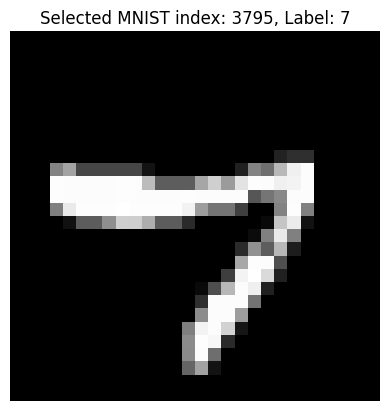

CNNModel(
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pad): ZeroPad2d((2, 1, 2, 1))
  (conv2): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=392, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [8]:
# ====================================================
# 3. Load full PyTorch model
# ====================================================

model = torch.load(
    'C:/Users/isang/OneDrive/Desktop/Python/model.pth',
    map_location='cpu',
    weights_only=False
)
true_label = generate()
model.eval()

##

## Run CNN Accelerator Testbench

### then, excute next code

In [9]:
# ====================================================
# 4. Load NPU outputs & build tensor_acc
# ====================================================
outputs = []
for i in range(8):
    fname = (
        'C:/MY/Vivado/UniNPU/UniNPU.srcs/data/'
        f'NPU_Run_Data/Output/output_npu_l2c0{i}.txt'
    )
    flat = load_verilog_bin(fname)
    outputs.append(flat)
stacked = np.stack(outputs, axis=1) / 2.0
arr = stacked.reshape(1, 7, 7, 8)
arr = np.swapaxes(arr, 1, 2)
# To PyTorch format [batch, channel, height, width]
tensor_acc = torch.from_numpy(arr.transpose(0, 3, 1, 2)).float()

In [10]:
# ====================================================
# 5. Accelerator inference (dropout1 -> flatten -> fc1 -> dropout2 -> fc2)
# ====================================================
with torch.no_grad():
    h = model.dropout1(tensor_acc)
    h = h.reshape(h.size(0), -1)
    h = F.relu(model.fc1(h))
    h = model.dropout2(h)
    logits_acc = model.fc2(h)
    probs_acc = F.softmax(logits_acc, dim=1).numpy()
    pred_acc0 = np.argmax(probs_acc, axis=1)
    pred_acc = np.array([true_label])

print('The Answer by accelerator is', pred_acc)

The Answer by accelerator is [7]
